In [1]:
import numpy as np
import PWBeamformer as pwb
import matplotlib.pyplot as plt
import scipy.signal as sig
import pyus.data.io as dio

In [2]:
# Load file
print("Reading file")
filedir = "/datacommons/ultrasound/TIMuscle/Phantoms/20230208_developmentrf/acq_wire/"
filename = "20230208_153318694"

params = dio.loadmat(filename=filename+"_RF", filedir=filedir)
nsamp = 2*4*(params['track_params']['rx']['endDepth'] - params['track_params']['startDepth'])
nsamp = int(np.ceil(nsamp/128) * 128)
rf_raw = np.fromfile(filedir+filename+"_RF.bin", dtype=np.int16)
rf_raw = rf_raw.reshape((-1,params['trans']['nele']), order='f')

na = params['track_params']['rf']['na']
numrot = params['track_params']['numrot']

print("Reshaping")
rf = []
for rot in range(numrot):
    rotdata = []
    for ang in range(na):
        indmin = (rot*na + ang)*nsamp
        indmax = indmin + nsamp
        rotdata.append(rf_raw[indmin:indmax,:])
    rf.append(rotdata)
rf = np.array(rf).transpose(2, 3, 1, 0).astype(float)
fs = 20.833E6

print("UPsamplng")
usf_ax = int(8)
t = params['track_params']['startDepth']/params['f'] + np.arange(nsamp)/fs
tstart = params['track_params']['startDepth']/params['f']
rf, t = sig.resample(rf, rf.shape[0]*usf_ax, t, axis=0)
Ts = np.mean(np.diff(t))
Nt = len(t)

print("Applying TGC")
tgc = 10**(t*3.6E3)
tgc = tgc.reshape((-1,1,1,1))
rf = rf*tgc

# IMaging parameters
c = 1450       # speed of sound in medium [m/s - coldish water]
fs = 20.833E6   # sampling frequency [Hz]
ddeg = params['track_params']['rf']['ddeg']
dtheta = ddeg * np.pi/180
na = params['track_params']['rf']['na']
thetas = dtheta*(np.arange(na)-(na-1)/2)

# Transducer parameters
dele = 0.298E-3 # element spacing [meters]
nele = 128      # number of elements

# Recon parameters
dz = c/(4*fs)
zmin = 1.5E-3
zmax = 40E-3
dx = 0.2E-3
xmin = -dele * (nele-1)/2
xmax = dele * (nele-1)/2
dy = 0.2E-3
ymin = 0E-3
ymax = 0E-3

# Generate element grid
xele = dele*(np.arange(nele) - (nele-1)/2)
yele = 0
zele = 0
Xele, Yele, Zele = np.meshgrid(xele, yele, zele)
eles = np.array([Xele.flatten(), Yele.flatten(), Zele.flatten()]).T

# Generate recon grid
xgrid = np.arange(xmin, xmax, dx)
ygrid = 0 #np.arange(ymin, ymax, dy)
zgrid = np.arange(zmin, zmax, dz)
Xgrid, Ygrid, Zgrid = np.meshgrid(xgrid, ygrid, zgrid)
field = np.array([Xgrid.flatten(), Ygrid.flatten(), Zgrid.flatten()]).T

trefs = []
for inda in range(na):
    tref = np.sin(thetas[inda])*xele/c
    tref = tref - np.min(tref)
    trefs.append(tref)
trefs = np.array(trefs).flatten()

Reading file
Reshaping
UPsamplng
Applying TGC


In [3]:
# initialize beamformer
funcparams = {}
funcparams['c'] = c
funcparams['fnum'] = 2
funcparams['points'] = field
funcparams['trefs'] = trefs
funcparams['refs'] = np.tile(eles, (na,1))
funcparams['alphas'] = np.repeat(thetas, nele)
funcparams['nsamp'] = rf.shape[0]
funcparams['fs'] = float(1/Ts)
funcparams['tstart'] = float(5/params['f'])

for (k, v) in funcparams.items():
    try:
        print(k, v.shape)
    except Exception as e:
        print(k, v, "welp...")

funcparams['fs']

c 1450 welp...
fnum 2 welp...
points (420470, 3)
trefs (1408,)
refs (1408, 3)
alphas (1408,)
nsamp 12288 welp...
fs 166664000.00000012 welp...
tstart 9.615384615384615e-07 welp...


166664000.00000012

In [4]:
bmfrm = pwb.PWBeamformer(**funcparams)

Initializing a PWBeamformer...
  Formatting input parameters...
    Generating masks
    Generating Transmission Tabs


In [5]:
print("Slicing data")
rfslice = rf[:,:,0,17]
for ind in range(rf.shape[2]-1):
    rfslice = np.concatenate((rfslice, rf[:,:,ind+1,17]), axis = 1)
rfslice.shape

Slicing data


(12288, 1408)

In [6]:
bmfrm.__init_masks__()
bmfrmparams = pwb.__BMFRM_PARAMS__[bmfrm.id]

    Generating masks


In [12]:
print("Slicing data")
allsummed = []
for inda in range(numrot):
    rfslice = rf[:,:,0,inda]
    for ind in range(rf.shape[2]-1):
        rfslice = np.concatenate((rfslice, rf[:,:,ind+1,inda]), axis = 1)
    print("Beamforming...")
    summed = bmfrm(rfslice).reshape((len(zgrid), len(xgrid)), order='f')
    allsummed.append(summed)
print("Finished with it")

Slicing data
Beamforming...
Beamforming
  Copying data...
  Starting pool...
    Pool active
  Summing results...
Beamforming...
Beamforming
  Copying data...
  Starting pool...
    Pool active
  Summing results...
Beamforming...
Beamforming
  Copying data...
  Starting pool...
    Pool active
  Summing results...
Beamforming...
Beamforming
  Copying data...
  Starting pool...
    Pool active
  Summing results...
Beamforming...
Beamforming
  Copying data...
  Starting pool...
    Pool active
  Summing results...
Beamforming...
Beamforming
  Copying data...
  Starting pool...
    Pool active
  Summing results...
Beamforming...
Beamforming
  Copying data...
  Starting pool...
    Pool active
  Summing results...
Beamforming...
Beamforming
  Copying data...
  Starting pool...
    Pool active
  Summing results...
Beamforming...
Beamforming
  Copying data...
  Starting pool...
    Pool active
  Summing results...
Beamforming...
Beamforming
  Copying data...
  Starting pool...
    Pool activ

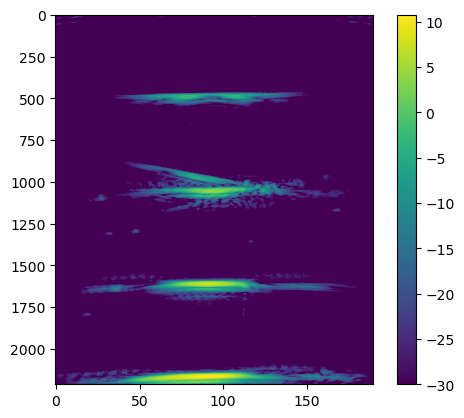

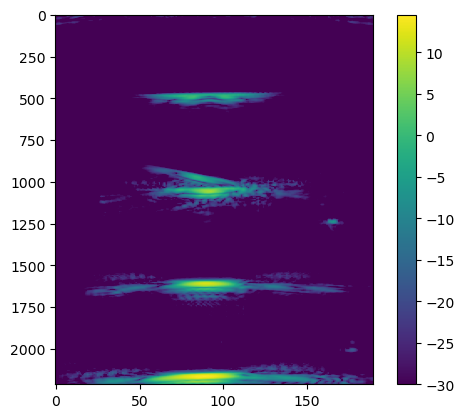

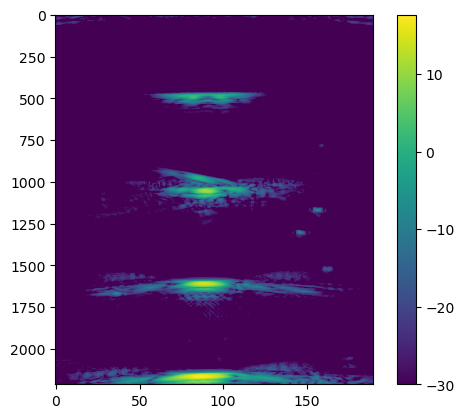

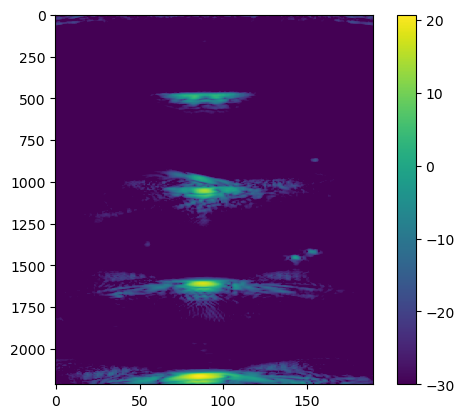

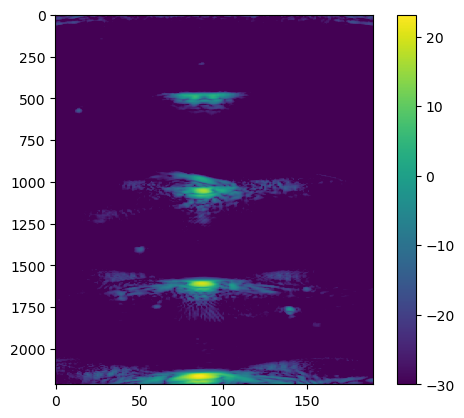

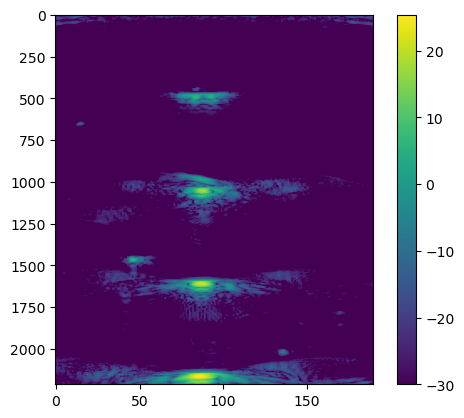

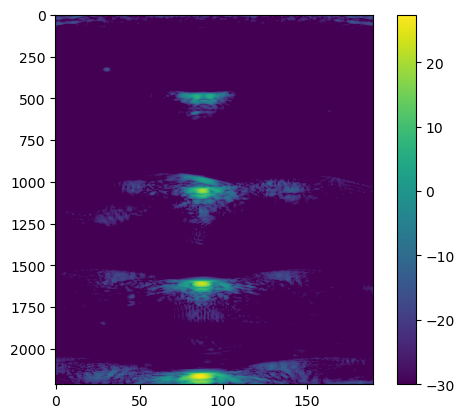

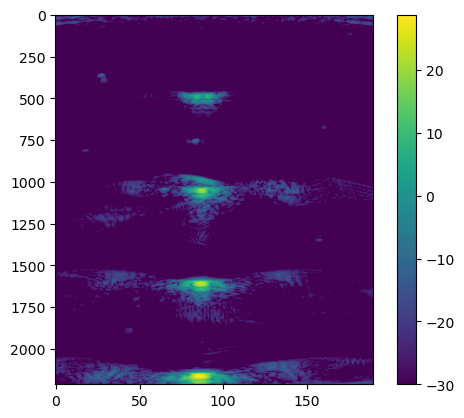

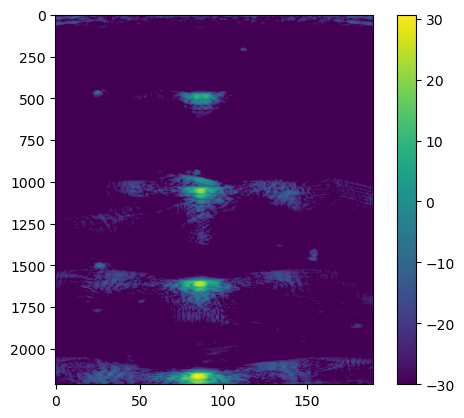

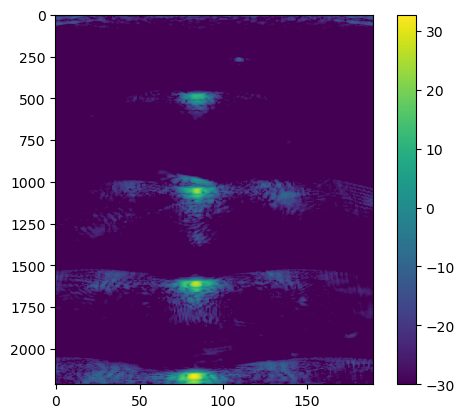

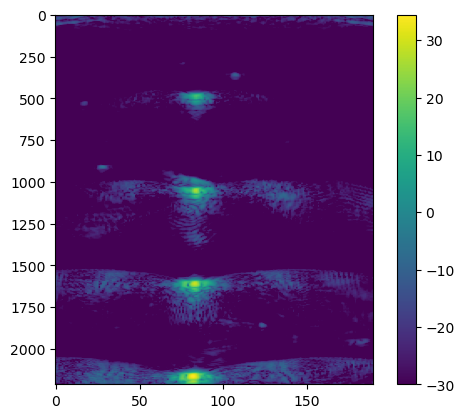

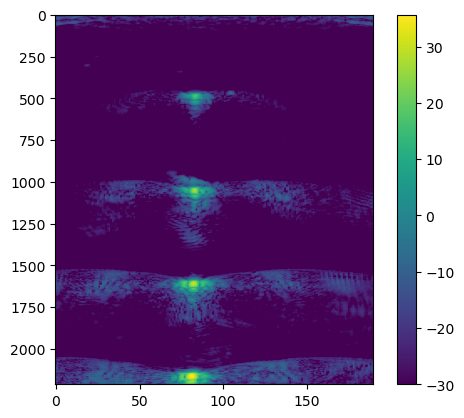

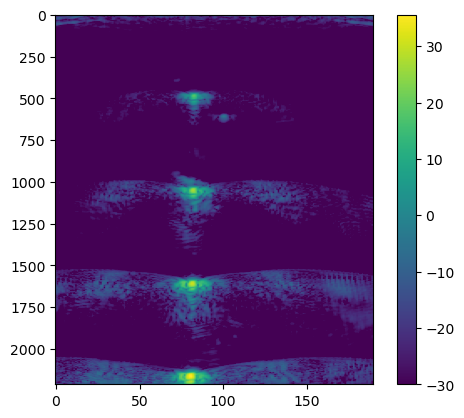

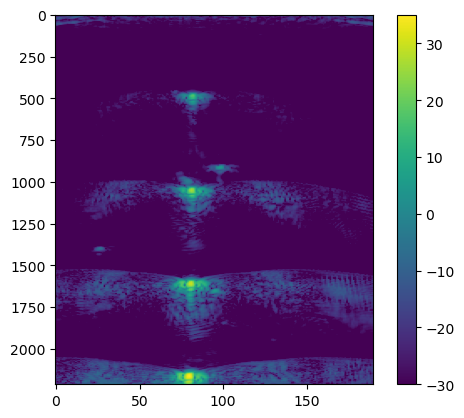

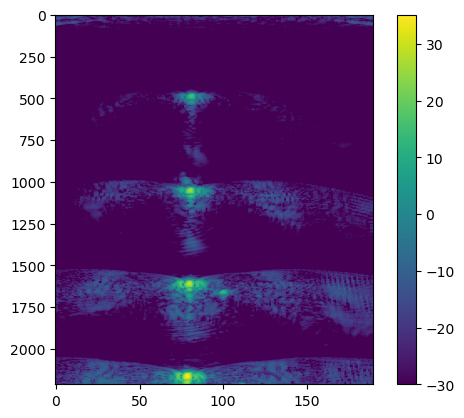

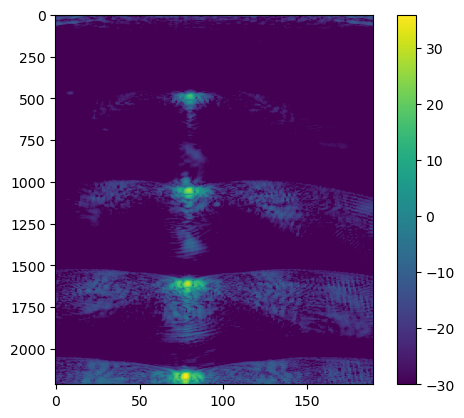

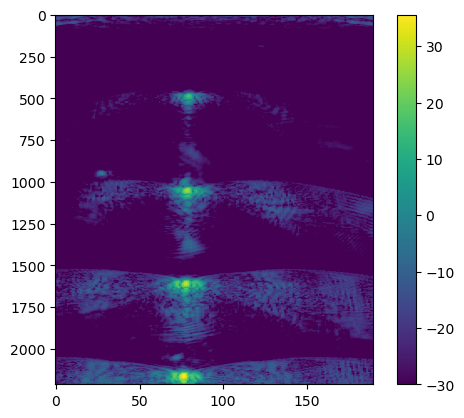

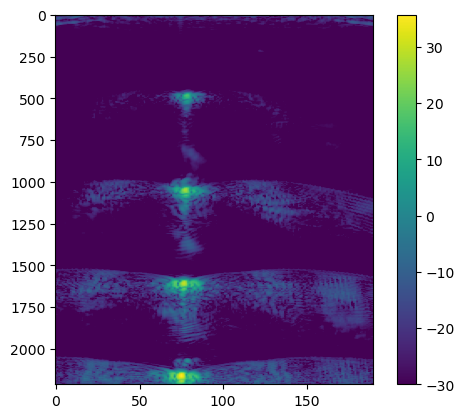

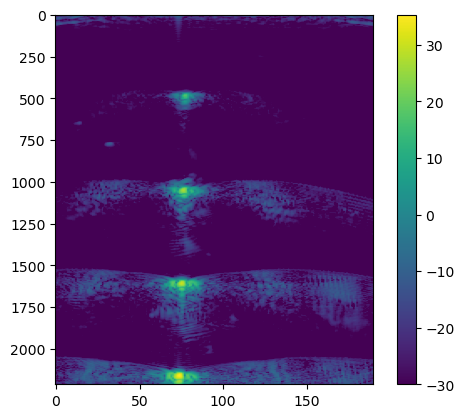

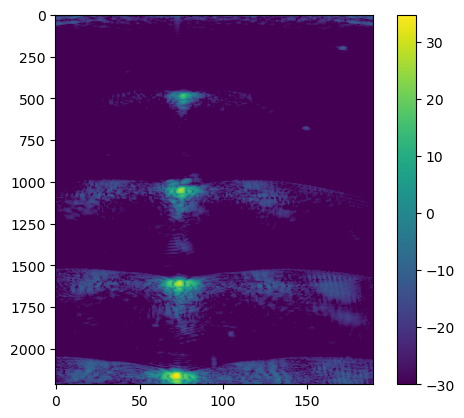

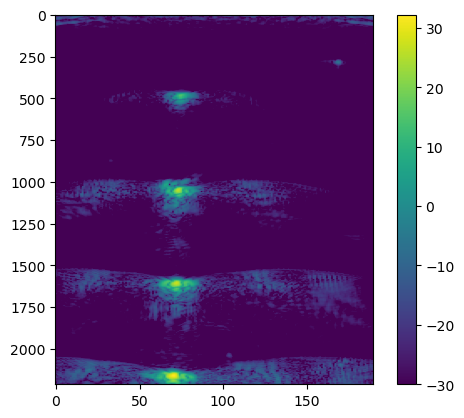

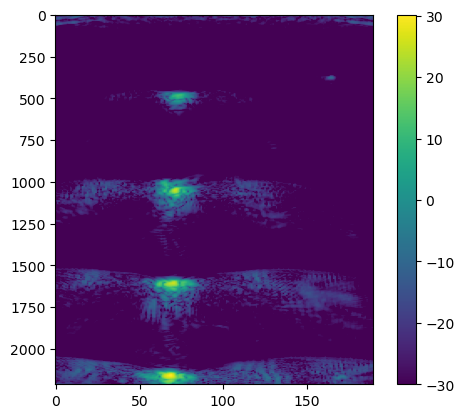

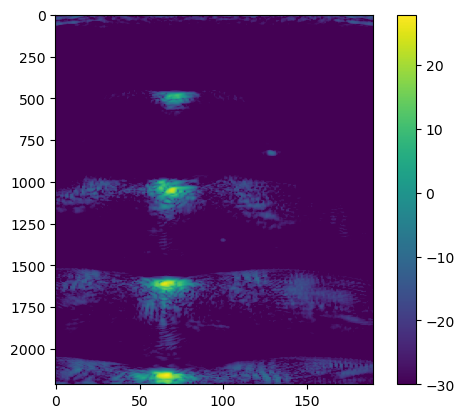

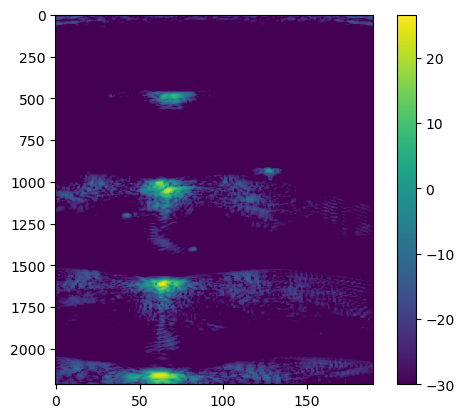

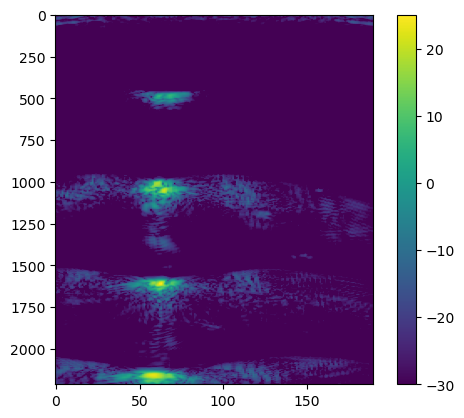

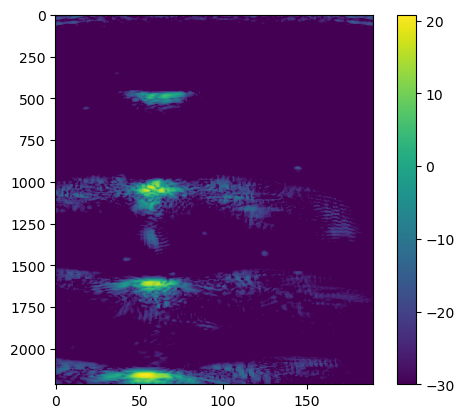

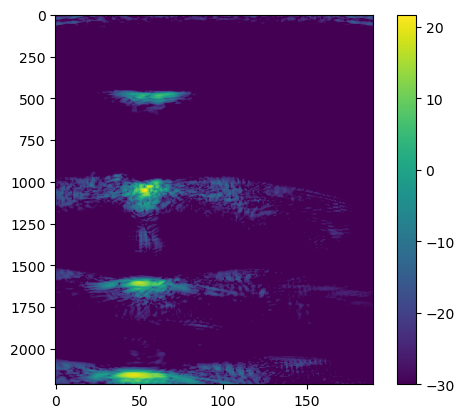

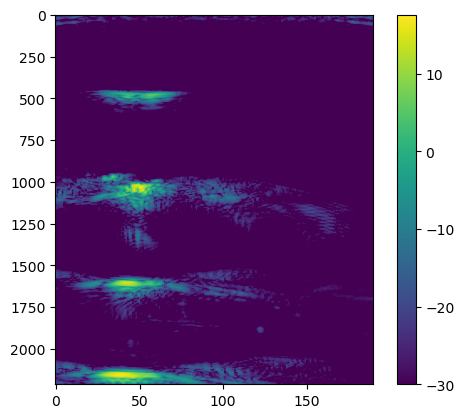

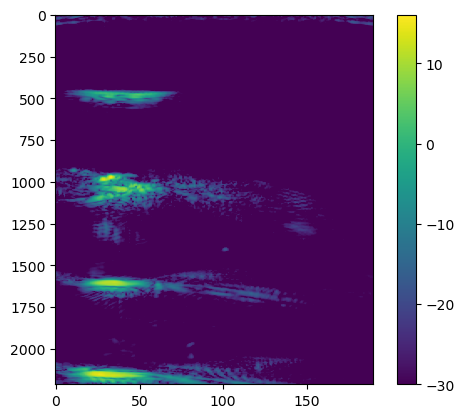

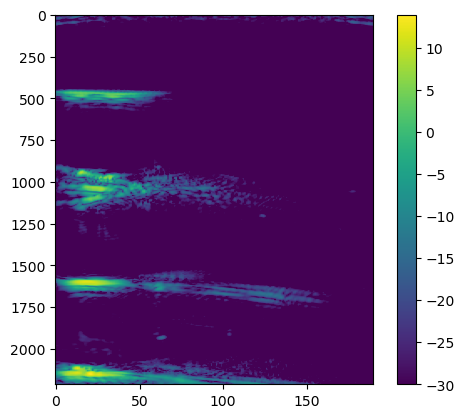

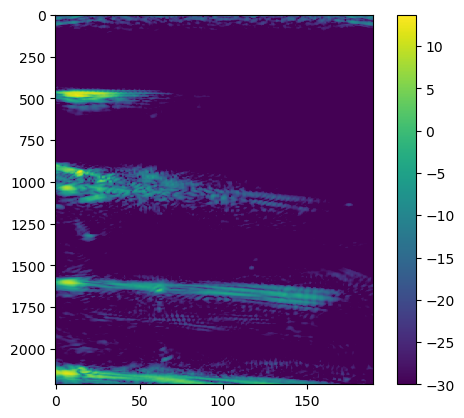

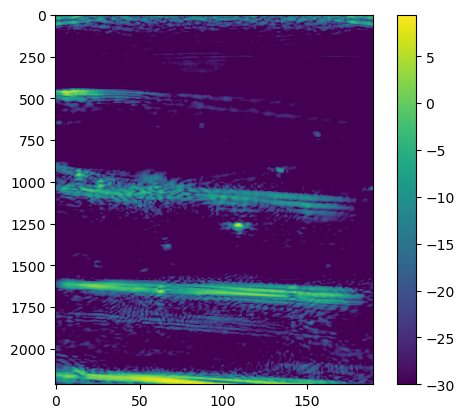

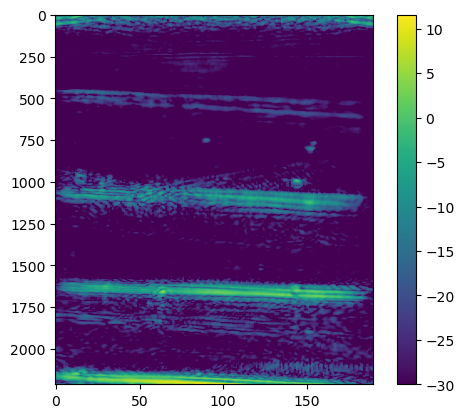

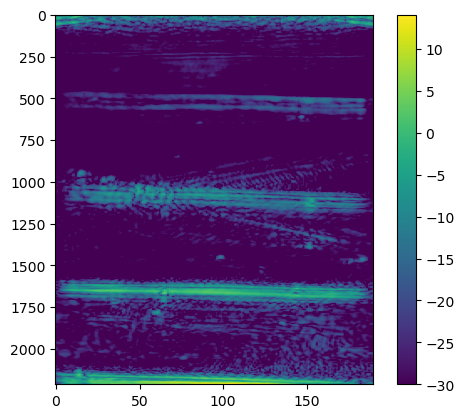

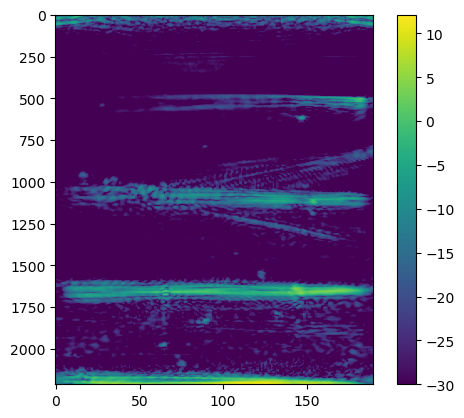

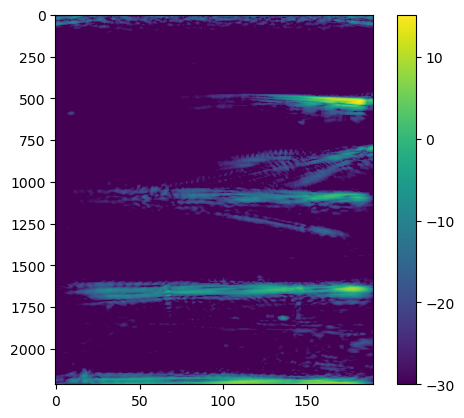

In [13]:
for indr in range(numrot):
    summed = allsummed[indr]
    env = np.abs(sig.hilbert(summed, axis=0))
    logged = 20*np.log10(env/np.percentile(env,99))
    plt.figure()
    plt.imshow(logged, aspect = 0.1, vmin=-30)
    plt.colorbar()
    plt.show()